# Case study
Given a user’s past reviews on Yelp (available from yelp-challenge dataset),

When the user writes a review for a business she hasn't reviewed before,

How likely will it be a Five-Star review?

- Load data
- Visualize the data
- Featurize the data
- Join tables to populate the features
- Model the data: Logistic regression
- Evaluate the model
- Make prediction with the model

# Load data

In [9]:
import pandas as pd

PATH = '/scratch/xun/docs/yelp_dataset_challenge_academic_dataset/'
biz_df = pd.read_csv(PATH + 'yelp_academic_dataset_business.csv')
user_df = pd.read_csv(PATH + 'yelp_academic_dataset_user.csv')
review_df = pd.read_csv(PATH + 'yelp_academic_dataset_review.csv')

In [10]:
review_df = review_df.set_index('review_id')
user_df = user_df.set_index('user_id')
biz_df = biz_df.set_index('business_id')

# Visualize the data

## Example: Plot distribution of review star ratings

In [11]:
import seaborn as sns
%matplotlib inline

# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

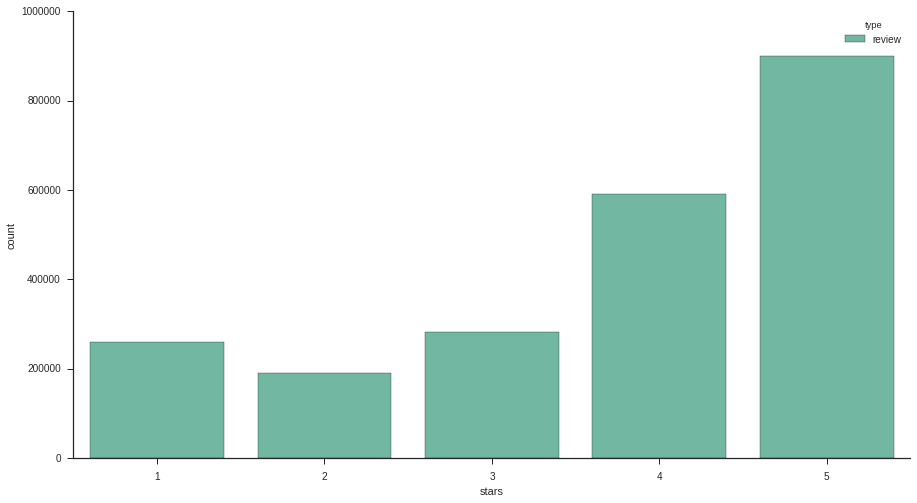

In [12]:
ax = sns.countplot(x='stars', data=review_df, hue='type')
# Removing spines
sns.despine()

## Example: Plot review star ratings by year

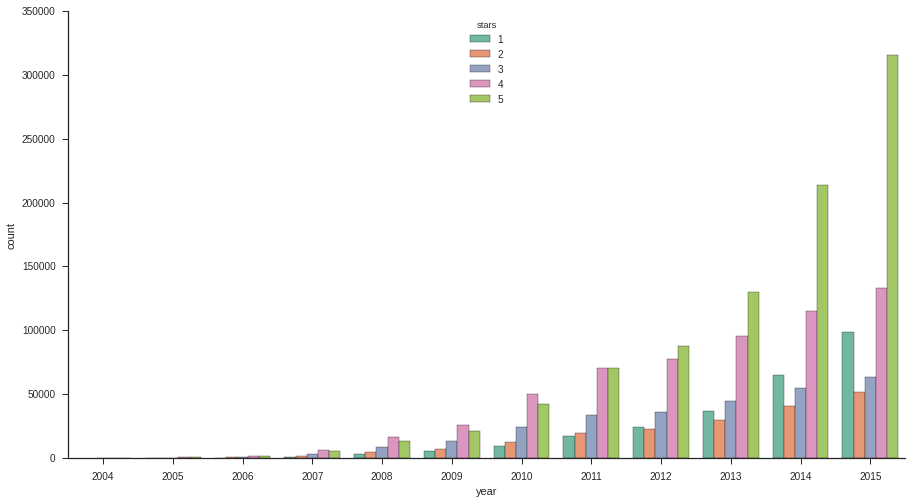

In [13]:
review_df['datetime'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['datetime'].dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
sns.despine()

# Featurize the data

- Convert date string to date delta
  - For example, business_age
- Convert strings to categorical features
  - For example, noise level: quiet, loud, very loud.
- Drop unused features
  - For example, business_name

In [14]:
def calculate_date_delta(df, from_column, to_column):
    datetime = pd.to_datetime(df[from_column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(from_column, axis=1, inplace=True)

In [15]:
def to_length(df, from_column, to_column):
    df[to_column] = df[from_column].apply(lambda x: len(x))
    df.drop(from_column, axis=1, inplace=True)

In [16]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [17]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [18]:
FILL_WITH = 0.0

In [19]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        #print 'categories for ', column, ' include ', df[column].cat.categories

In [20]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        #print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        #print 'becomes ', df[column].cat.categories

In [21]:
calculate_date_delta(df=review_df, from_column='date', to_column='date_delta')

In [22]:
to_length(df=review_df, from_column='text', to_column='text_len')

In [23]:
drop_columns(df=review_df, columns=['type', 'year', 'datetime'])

In [24]:
review_df.fillna(value=0.0, inplace=True)

In [25]:
calculate_date_delta(df=user_df, from_column='yelping_since', to_column='date_delta')

In [26]:
to_length(df=user_df, from_column='friends', to_column='friends_count')

In [27]:
to_length(df=user_df, from_column='elite', to_column='elite_count')

In [28]:
drop_columns(df=user_df, columns=['name', 'type'])

In [29]:
user_df.fillna(value=0.0, inplace=True)

In [30]:
drop_columns(
    df=biz_df,
    columns=[
        'type',
        'name',
        'city',
        'full_address',
        'state',
        'categories',
        'longitude',
        'latitude',
        'neighborhoods',
        'hours.Monday.open',
        'hours.Monday.close',
        'hours.Tuesday.open',
        'hours.Tuesday.close',
        'hours.Wednesday.open',
        'hours.Wednesday.close',
        'hours.Thursday.open',
        'hours.Thursday.close',
        'hours.Friday.open',
        'hours.Friday.close',
        'hours.Saturday.open',
        'hours.Saturday.close',
        'hours.Sunday.open',
        'hours.Sunday.close',
    ]
)

In [31]:
to_cat_columns = [
    'attributes.Ambience.casual',
    'attributes.Attire',
    'attributes.Alcohol',
    'attributes.Noise Level',
    'attributes.Smoking',
    'attributes.Wi-Fi',
    'attributes.Ages Allowed',
    'attributes.BYOB/Corkage',
]
to_category(
    df=biz_df,
    columns=to_cat_columns,
)

In [32]:
biz_df.fillna(value=FILL_WITH, inplace=True)

In [33]:
category_rename_to_int(
    df=biz_df,
    columns=to_cat_columns,
)

# Join tables to populate the features

Join three tables (review, biz, user) to one (review-with-all-info).
Each join is a many-to-one join.

In [34]:
# The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.
review_join_user = review_df.join(user_df, on='user_id', lsuffix='_review', rsuffix='_user')

In [35]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id', rsuffix='_biz')

In [36]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

# Identify data X and target y
Data X: all features we gathered from business, user, and review tables.

Target y: what we'd like to predict: Whether the review is Five-star or not.

In [37]:
# target y is whether a review is five-star
y = review_join_user_join_biz.stars.apply(lambda x: x == 5)

# We've already dropped not informative features data X
X = review_join_user_join_biz
review_join_user_join_biz.drop('stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

# Split training set and testing set

In [38]:
from sklearn.cross_validation import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
#print 'features', features

training data shape (1668909, 99)
test data shape (556304, 99)
converted label data shape (1668909,)


# Model the data: Logistic regression

Logistic regression estimates the probability of a binary response based on one or more features.

Here we estimate the probability of a review being five-star.

In [40]:
from sklearn import preprocessing

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
from sklearn.cross_validation import cross_val_score
import numpy as np

# Function used to print cross-validation scores
def training_score(est, X, y, cv):
    acc = cross_val_score(est, X, y, cv = cv, scoring='accuracy')
    roc = cross_val_score(est, X, y, cv = cv, scoring='roc_auc')
    print '5-fold Train CV | Accuracy:', round(np.mean(acc), 3),'+/-', \
    round(np.std(acc), 3),'| ROC AUC:', round(np.mean(roc), 3), '+/-', round(np.std(roc), 3)

In [42]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression()

In [43]:
from sklearn.cross_validation import StratifiedKFold

# cross-validation 
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True)

In [44]:
# print cross-validation scores
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=cv)

5-fold Train CV | Accuracy: 0.754 +/- 0.0 | ROC AUC: 0.824 +/- 0.001


# Evaluation via Confusion Matrix 

False positive (upper right).

False negative (bottom left)

In [45]:
# Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Run classifier
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[ 0.83402455  0.16597545]
 [ 0.36468911  0.63531089]]


/nail/home/xun/venv/ipynb/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


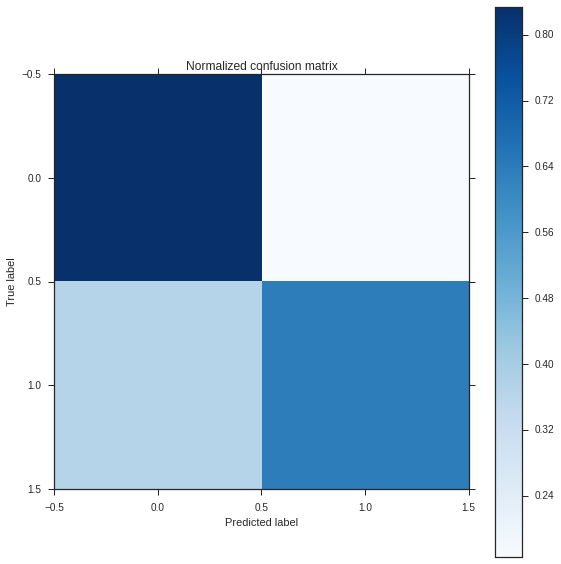

In [46]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

# Make prediction with the model

Randomly pick an anonymous user from the dataset.

Example: Predict whether the user will give a business a Five-star rating.

In [47]:
def predict_given_user_biz(user, biz, biz_name):
    a_user = user.copy()
    a_biz = biz.copy()
    for column in {
        'review_count',
        'stars',
    }:
        a_biz[column+'_biz'] = a_biz[column]
        a_biz.drop(column, axis=1, inplace=True)
    for column in {
        'date_delta',
        'votes.funny',
        'votes.useful',
        'votes.cool',
    }:
        a_user[column+'_user'] = a_user[column]
        a_user.drop(column, axis=1, inplace=True)
    a_X_test = pd.concat([a_user.iloc[0], a_biz.iloc[0]], axis=0).to_frame().transpose()
    a_X_test['review_id'] = 'xun_on_postino-arcadia-phoenix'
    a_X_test = a_X_test.set_index('review_id')
    for column in {
        'votes.cool_review',
        'votes.funny_review',
        'votes.useful_review',
        'date_delta_review',
        'text_len',
    }:
        a_X_test[column] = ""
        a_X_test[column] = '0.0'
    # XXX(xun): fix this
    a_X_test['attributes.BYOB/Corkage'] = 4
    #a_X_test
    a_X_test_scaled = scaler.transform(a_X_test)
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    print 'prediction for user ', a_user.index.values[0], ' on business ', biz_name, ' is ', a_y_pred[0]

In [48]:
a_user = user_df[user_df.index == 'HcOguFNyg9jNkNpTBD2D3g']
a_user.review_count

user_id
HcOguFNyg9jNkNpTBD2D3g    4
Name: review_count, dtype: int64

In [49]:
a_biz = biz_df[biz_df.index == 'SDwYQ6eSu1htn8vHWv128g']

# https://www.yelp.com/biz/postino-arcadia-phoenix

<img src="postino-arcadia-phoenix.png" alt="postino-arcadia-phoenix" width="800">


In [57]:
predict_given_user_biz(user=a_user, biz=a_biz, biz_name="Postino Arcadia Phoenix")

prediction for user  HcOguFNyg9jNkNpTBD2D3g  on business  Postino Arcadia Phoenix  is  True


In [58]:
another_user = user_df[user_df.index == 'o625WyBtvJ_G3s0FRr6RmQ']
another_user.review_count

user_id
o625WyBtvJ_G3s0FRr6RmQ    10
Name: review_count, dtype: int64

In [51]:
another_biz = biz_df[biz_df.index == '1n0n_-Iz0e3iVpH8sereiA']

# https://www.yelp.com/biz/port-authority-of-allegheny-county-pittsburgh

<img src="port-authority-of-allegheny-county-pittsburgh.png" alt="port-authority-of-allegheny-county-pittsburgh" width="800">

In [52]:
predict_given_user_biz(user=a_user, biz=another_biz, biz_name="Postino Arcadia Phoenix")

prediction for user  HcOguFNyg9jNkNpTBD2D3g  on business  Postino Arcadia Phoenix  is  True


In [54]:
predict_given_user_biz(user=another_user, biz=another_biz, biz_name="Port Authority of Allegheny County")

prediction for user  o625WyBtvJ_G3s0FRr6RmQ  on business  Port Authority of Allegheny County  is  False
